# Probabilistic validation of AMPC on the Polymerization Reactor Example

In this Jupyter Notebook we demonstrate a probabilistic validation scheme for AMPC controllers. In the process we will also show how to incoporate uncertainty into the MPC controller and the simulation using do-mpc.

## Models
First lets define a model with fixed parameters we will use for for a nominal MPC and a MPC wit backoff constraints

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from casadi import *
from do_mpc.tools import Timer
import jdc
# Add do_mpc to path. This is not necessary if it was installed via pip
import os
import torch
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

In [21]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model_fixed = do_mpc.model.Model(model_type)
# Certain parameters
R           = 8.314			#gas constant
T_F         = 25 + 273.15	#feed temperature
E_a         = 8500.0		#activation energy
delH_R      = 950.0*1.00	#sp reaction enthalpy
A_tank      = 65.0			#area heat exchanger surface jacket 65

k_0         = 7.0*1.00		#sp reaction rate
k_U2        = 32.0			#reaction parameter 1
k_U1        = 4.0			#reaction parameter 2
w_WF        = .333			#mass fraction water in feed
w_AF        = .667			#mass fraction of A in feed

delH_R = 950
k_0 =    7

m_M_KW      = 5000.0		#mass of coolant in jacket
fm_M_KW     = 300000.0		#coolant flow in jacket 300000;
m_AWT_KW    = 1000.0		#mass of coolant in EHE
fm_AWT_KW   = 100000.0		#coolant flow in EHE
m_AWT       = 200.0			#mass of product in EHE
fm_AWT      = 20000.0		#product flow in EHE
m_S         = 39000.0		#mass of reactor steel

c_pW        = 4.2			#sp heat cap coolant
c_pS        = .47			#sp heat cap steel
c_pF        = 3.0			#sp heat cap feed
c_pR        = 5.0			#sp heat cap reactor contents

k_WS        = 17280.0		#heat transfer coeff water-steel
k_AS        = 3600.0		#heat transfer coeff monomer-steel
k_PS        = 360.0			#heat transfer coeff product-steel

alfa        = 5*20e4*3.6

p_1         = 1.0

m_W =         model_fixed.set_variable('_x', 'm_W')
m_A =         model_fixed.set_variable('_x', 'm_A')
m_P =         model_fixed.set_variable('_x', 'm_P')
T_R =         model_fixed.set_variable('_x', 'T_R')
T_S =         model_fixed.set_variable('_x', 'T_S')
Tout_M =      model_fixed.set_variable('_x', 'Tout_M')
T_EK =        model_fixed.set_variable('_x', 'T_EK')
Tout_AWT =    model_fixed.set_variable('_x', 'Tout_AWT')
accum_monom = model_fixed.set_variable('_x', 'accum_monom')
T_adiab =     model_fixed.set_variable('_x', 'T_adiab')
m_dot_f = model_fixed.set_variable('_u', 'm_dot_f')
T_in_M =  model_fixed.set_variable('_u', 'T_in_M')
T_in_EK = model_fixed.set_variable('_u', 'T_in_EK')

U_m    = m_P / (m_A + m_P)
m_ges  = m_W + m_A + m_P
k_R1   = k_0 * exp(- E_a/(R*T_R)) * ((k_U1 * (1 - U_m)) + (k_U2 * U_m))
k_R2   = k_0 * exp(- E_a/(R*T_EK))* ((k_U1 * (1 - U_m)) + (k_U2 * U_m))
k_K    = ((m_W / m_ges) * k_WS) + ((m_A/m_ges) * k_AS) + ((m_P/m_ges) * k_PS)

# Differential equations
dot_m_W = m_dot_f * w_WF
model_fixed.set_rhs('m_W', dot_m_W)
dot_m_A = (m_dot_f * w_AF) - (k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))) - (p_1 * k_R2 * (m_A/m_ges) * m_AWT)
model_fixed.set_rhs('m_A', dot_m_A)
dot_m_P = (k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))) + (p_1 * k_R2 * (m_A/m_ges) * m_AWT)
model_fixed.set_rhs('m_P', dot_m_P)

dot_T_R = 1./(c_pR * m_ges)   * ((m_dot_f * c_pF * (T_F - T_R)) - (k_K *A_tank* (T_R - T_S)) - (fm_AWT * c_pR * (T_R - T_EK)) + (delH_R * k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))))
model_fixed.set_rhs('T_R', dot_T_R)
model_fixed.set_rhs('T_S', 1./(c_pS * m_S)     * ((k_K *A_tank* (T_R - T_S)) - (k_K *A_tank* (T_S - Tout_M))))
model_fixed.set_rhs('Tout_M', 1./(c_pW * m_M_KW)  * ((fm_M_KW * c_pW * (T_in_M - Tout_M)) + (k_K *A_tank* (T_S - Tout_M))))
model_fixed.set_rhs('T_EK', 1./(c_pR * m_AWT)   * ((fm_AWT * c_pR * (T_R - T_EK)) - (alfa * (T_EK - Tout_AWT)) + (p_1 * k_R2 * (m_A/m_ges) * m_AWT * delH_R)))
model_fixed.set_rhs('Tout_AWT', 1./(c_pW * m_AWT_KW)* ((fm_AWT_KW * c_pW * (T_in_EK - Tout_AWT)) - (alfa * (Tout_AWT - T_EK))))
model_fixed.set_rhs('accum_monom', m_dot_f)
model_fixed.set_rhs('T_adiab', delH_R/(m_ges*c_pR)*dot_m_A-(dot_m_A+dot_m_W+dot_m_P)*(m_A*delH_R/(m_ges*m_ges*c_pR))+dot_T_R)

model_fixed.setup()


## Model with uncertain parameters
We now consider the same model but with two uncertainties. The values will be set for the simulator and the MPC, therefore enabling a robust multistage MPC.

In [18]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
# Certain parameters
R           = 8.314			#gas constant
T_F         = 25 + 273.15	#feed temperature
E_a         = 8500.0		#activation energy
delH_R      = 950.0*1.00	#sp reaction enthalpy
A_tank      = 65.0			#area heat exchanger surface jacket 65

k_0         = 7.0*1.00		#sp reaction rate
k_U2        = 32.0			#reaction parameter 1
k_U1        = 4.0			#reaction parameter 2
w_WF        = .333			#mass fraction water in feed
w_AF        = .667			#mass fraction of A in feed

delH_R = model.set_variable('_p', 'delH_R')
k_0 =    model.set_variable('_p', 'k_0')

m_M_KW      = 5000.0		#mass of coolant in jacket
fm_M_KW     = 300000.0		#coolant flow in jacket 300000;
m_AWT_KW    = 1000.0		#mass of coolant in EHE
fm_AWT_KW   = 100000.0		#coolant flow in EHE
m_AWT       = 200.0			#mass of product in EHE
fm_AWT      = 20000.0		#product flow in EHE
m_S         = 39000.0		#mass of reactor steel

c_pW        = 4.2			#sp heat cap coolant
c_pS        = .47			#sp heat cap steel
c_pF        = 3.0			#sp heat cap feed
c_pR        = 5.0			#sp heat cap reactor contents

k_WS        = 17280.0		#heat transfer coeff water-steel
k_AS        = 3600.0		#heat transfer coeff monomer-steel
k_PS        = 360.0			#heat transfer coeff product-steel

alfa        = 5*20e4*3.6

p_1         = 1.0

m_W =         model.set_variable('_x', 'm_W')
m_A =         model.set_variable('_x', 'm_A')
m_P =         model.set_variable('_x', 'm_P')
T_R =         model.set_variable('_x', 'T_R')
T_S =         model.set_variable('_x', 'T_S')
Tout_M =      model.set_variable('_x', 'Tout_M')
T_EK =        model.set_variable('_x', 'T_EK')
Tout_AWT =    model.set_variable('_x', 'Tout_AWT')
accum_monom = model.set_variable('_x', 'accum_monom')
T_adiab =     model.set_variable('_x', 'T_adiab')
m_dot_f = model.set_variable('_u', 'm_dot_f')
T_in_M =  model.set_variable('_u', 'T_in_M')
T_in_EK = model.set_variable('_u', 'T_in_EK')

U_m    = m_P / (m_A + m_P)
m_ges  = m_W + m_A + m_P
k_R1   = k_0 * exp(- E_a/(R*T_R)) * ((k_U1 * (1 - U_m)) + (k_U2 * U_m))
k_R2   = k_0 * exp(- E_a/(R*T_EK))* ((k_U1 * (1 - U_m)) + (k_U2 * U_m))
k_K    = ((m_W / m_ges) * k_WS) + ((m_A/m_ges) * k_AS) + ((m_P/m_ges) * k_PS)

# Differential equations
dot_m_W = m_dot_f * w_WF
model.set_rhs('m_W', dot_m_W)
dot_m_A = (m_dot_f * w_AF) - (k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))) - (p_1 * k_R2 * (m_A/m_ges) * m_AWT)
model.set_rhs('m_A', dot_m_A)
dot_m_P = (k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))) + (p_1 * k_R2 * (m_A/m_ges) * m_AWT)
model.set_rhs('m_P', dot_m_P)

dot_T_R = 1./(c_pR * m_ges)   * ((m_dot_f * c_pF * (T_F - T_R)) - (k_K *A_tank* (T_R - T_S)) - (fm_AWT * c_pR * (T_R - T_EK)) + (delH_R * k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))))
model.set_rhs('T_R', dot_T_R)
model.set_rhs('T_S', 1./(c_pS * m_S)     * ((k_K *A_tank* (T_R - T_S)) - (k_K *A_tank* (T_S - Tout_M))))
model.set_rhs('Tout_M', 1./(c_pW * m_M_KW)  * ((fm_M_KW * c_pW * (T_in_M - Tout_M)) + (k_K *A_tank* (T_S - Tout_M))))
model.set_rhs('T_EK', 1./(c_pR * m_AWT)   * ((fm_AWT * c_pR * (T_R - T_EK)) - (alfa * (T_EK - Tout_AWT)) + (p_1 * k_R2 * (m_A/m_ges) * m_AWT * delH_R)))
model.set_rhs('Tout_AWT', 1./(c_pW * m_AWT_KW)* ((fm_AWT_KW * c_pW * (T_in_EK - Tout_AWT)) - (alfa * (Tout_AWT - T_EK))))
model.set_rhs('accum_monom', m_dot_f)
model.set_rhs('T_adiab', delH_R/(m_ges*c_pR)*dot_m_A-(dot_m_A+dot_m_W+dot_m_P)*(m_A*delH_R/(m_ges*m_ges*c_pR))+dot_T_R)

model.setup()

## Controllers
We now define our batch of MPC controllers that we will use to train our AMPC controllers, which will be validated.
The first one is a nominal MPC using the model with fixed parameters. The seocnd one will use a backoff value on the temperature constraint. Finally, the third MPC is a robust multistage MPC.


In [24]:
mpc_nom = do_mpc.controller.MPC(model_fixed)
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 50.0/3600.0,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc_nom.set_param(**setup_mpc)
_x = model_fixed.x
mterm = - _x['m_P'] # terminal cost
lterm = - _x['m_P'] # stage cost

mpc_nom.set_objective(mterm=mterm, lterm=lterm)

mpc_nom.set_rterm(m_dot_f=0.002, T_in_M=0.004, T_in_EK=0.002) # penalty on control input changes
# auxiliary term
temp_range = 2.0
mpc_nom.settings.supress_ipopt_output()
# lower bound states
mpc_nom.bounds['lower','_x','m_W'] = 0.0
mpc_nom.bounds['lower','_x','m_A'] = 0.0
mpc_nom.bounds['lower','_x','m_P'] = 26.0

mpc_nom.bounds['lower','_x','T_R'] = 363.15 - temp_range
mpc_nom.bounds['lower','_x','T_S'] = 298.0
mpc_nom.bounds['lower','_x','Tout_M'] = 298.0
mpc_nom.bounds['lower','_x','T_EK'] = 288.0
mpc_nom.bounds['lower','_x','Tout_AWT'] = 288.0
mpc_nom.bounds['lower','_x','accum_monom'] = 0.0


mpc_nom.bounds['upper','_x','T_S'] = 400.0
mpc_nom.bounds['upper','_x','Tout_M'] = 400.0
mpc_nom.bounds['upper','_x','T_EK'] = 400.0
mpc_nom.bounds['upper','_x','Tout_AWT'] = 400.0
mpc_nom.bounds['upper','_x','accum_monom'] = 30000.0
mpc_nom.bounds['upper','_x','T_adiab'] = 382.15
mpc_nom.set_nl_cons('T_R_UB', _x['T_R'], ub=363.15+temp_range, soft_constraint=True, penalty_term_cons=1e4)

mpc_nom.bounds['lower','_u','m_dot_f'] = 0.0
mpc_nom.bounds['lower','_u','T_in_M'] = 333.15
mpc_nom.bounds['lower','_u','T_in_EK'] = 333.15

# upper bound inputs
mpc_nom.bounds['upper','_u','m_dot_f'] = 3.0e4
mpc_nom.bounds['upper','_u','T_in_M'] = 373.15
mpc_nom.bounds['upper','_u','T_in_EK'] = 373.15

mpc_nom.scaling['_x','m_W'] = 10
mpc_nom.scaling['_x','m_A'] = 10
mpc_nom.scaling['_x','m_P'] = 10
mpc_nom.scaling['_x','accum_monom'] = 10

# control inputs
mpc_nom.scaling['_u','m_dot_f'] = 100
mpc_nom.setup()

In [23]:
mpc_back = do_mpc.controller.MPC(model_fixed)
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 50.0/3600.0,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}
back=1.0
mpc_back.set_param(**setup_mpc)
_x = model.x
mterm = - _x['m_P'] # terminal cost
lterm = - _x['m_P'] # stage cost

mpc_back.set_objective(mterm=mterm, lterm=lterm)

mpc_back.set_rterm(m_dot_f=0.002, T_in_M=0.004, T_in_EK=0.002) # penalty on control input changes
# auxiliary term
temp_range = 2.0
mpc_back.settings.supress_ipopt_output()
# lower bound states
mpc_back.bounds['lower','_x','m_W'] = 0.0
mpc_back.bounds['lower','_x','m_A'] = 0.0
mpc_back.bounds['lower','_x','m_P'] = 26.0

mpc_back.bounds['lower','_x','T_R'] = 363.15 - temp_range
mpc_back.bounds['lower','_x','T_S'] = 298.0
mpc_back.bounds['lower','_x','Tout_M'] = 298.0
mpc_back.bounds['lower','_x','T_EK'] = 288.0
mpc_back.bounds['lower','_x','Tout_AWT'] = 288.0
mpc_back.bounds['lower','_x','accum_monom'] = 0.0


mpc_back.bounds['upper','_x','T_S'] = 400.0
mpc_back.bounds['upper','_x','Tout_M'] = 400.0
mpc_back.bounds['upper','_x','T_EK'] = 400.0
mpc_back.bounds['upper','_x','Tout_AWT'] = 400.0
mpc_back.bounds['upper','_x','accum_monom'] = 30000.0
mpc_back.bounds['upper','_x','T_adiab'] = 382.15
mpc_back.set_nl_cons('T_R_UB', _x['T_R'], ub=363.15+temp_range-back, soft_constraint=True, penalty_term_cons=1e4)

mpc_back.bounds['lower','_u','m_dot_f'] = 0.0
mpc_back.bounds['lower','_u','T_in_M'] = 333.15
mpc_back.bounds['lower','_u','T_in_EK'] = 333.15

# upper bound inputs
mpc_back.bounds['upper','_u','m_dot_f'] = 3.0e4
mpc_back.bounds['upper','_u','T_in_M'] = 373.15
mpc_back.bounds['upper','_u','T_in_EK'] = 373.15

mpc_back.scaling['_x','m_W'] = 10
mpc_back.scaling['_x','m_A'] = 10
mpc_back.scaling['_x','m_P'] = 10
mpc_back.scaling['_x','accum_monom'] = 10

# control inputs
mpc_back.scaling['_u','m_dot_f'] = 100
mpc_back.setup()

RuntimeError: Error in Function::Function for 'mterm' [SXFunction] at .../casadi/core/function.cpp:241:
.../casadi/core/function_internal.cpp:151: Error calling SXFunction::init for 'mterm':
.../casadi/core/sx_function.cpp:670: mterm::init: Initialization failed since variables [m_P] are free. These symbols occur in the output expressions but you forgot to declare these as inputs. Set option 'allow_free' to allow free variables.

In [6]:
mpc_rob = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 1,
    'open_loop': 0,
    't_step': 50.0/3600.0,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc_rob.set_param(**setup_mpc)
_x = model.x
mterm = - _x['m_P'] # terminal cost
lterm = - _x['m_P'] # stage cost

mpc_rob.set_objective(mterm=mterm, lterm=lterm)

mpc_rob.set_rterm(m_dot_f=0.002, T_in_M=0.004, T_in_EK=0.002) # penalty on control input changes
# auxiliary term
temp_range = 2.0
mpc_rob.settings.supress_ipopt_output()
# lower bound states
mpc_rob.bounds['lower','_x','m_W'] = 0.0
mpc_rob.bounds['lower','_x','m_A'] = 0.0
mpc_rob.bounds['lower','_x','m_P'] = 26.0

mpc_rob.bounds['lower','_x','T_R'] = 363.15 - temp_range
mpc_rob.bounds['lower','_x','T_S'] = 298.0
mpc_rob.bounds['lower','_x','Tout_M'] = 298.0
mpc_rob.bounds['lower','_x','T_EK'] = 288.0
mpc_rob.bounds['lower','_x','Tout_AWT'] = 288.0
mpc_rob.bounds['lower','_x','accum_monom'] = 0.0


mpc_rob.bounds['upper','_x','T_S'] = 400.0
mpc_rob.bounds['upper','_x','Tout_M'] = 400.0
mpc_rob.bounds['upper','_x','T_EK'] = 400.0
mpc_rob.bounds['upper','_x','Tout_AWT'] = 400.0
mpc_rob.bounds['upper','_x','accum_monom'] = 30000.0
mpc_rob.bounds['upper','_x','T_adiab'] = 382.15
mpc_rob.set_nl_cons('T_R_UB', _x['T_R'], ub=363.15+temp_range, soft_constraint=True, penalty_term_cons=1e4)

mpc_rob.bounds['lower','_u','m_dot_f'] = 0.0
mpc_rob.bounds['lower','_u','T_in_M'] = 333.15
mpc_rob.bounds['lower','_u','T_in_EK'] = 333.15

# upper bound inputs
mpc_rob.bounds['upper','_u','m_dot_f'] = 3.0e4
mpc_rob.bounds['upper','_u','T_in_M'] = 373.15
mpc_rob.bounds['upper','_u','T_in_EK'] = 373.15

mpc_rob.scaling['_x','m_W'] = 10
mpc_rob.scaling['_x','m_A'] = 10
mpc_rob.scaling['_x','m_P'] = 10
mpc_rob.scaling['_x','accum_monom'] = 10

# control inputs
mpc_rob.scaling['_u','m_dot_f'] = 100
mpc_rob.setup()

NameError: name 'model' is not defined

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [28]:
estimator = do_mpc.estimator.StateFeedback(model_fixed)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [29]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [30]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 50.0/3600.0
}

simulator.set_param(**params_simulator)

### Realizations of uncertain parameters

For the simulatiom, it is necessary to define the numerical realizations of the uncertain parameters in `p_num`.
First, we get the structure of the uncertain parameters:

In [31]:
p_num = simulator.get_p_template()
tvp_num = simulator.get_tvp_template()


We define a function which is called in each simulation step, which returns the current realizations of the parameters with respect to defined inputs (in this case `t_now`):

In [32]:
p_num['delH_R'] = 950 * np.random.uniform(0.75,1.25)
p_num['k_0'] = 7 * np.random.uniform(0.75*1.25)
def p_fun(t_now):
    return p_num
simulator.set_p_fun(p_fun)

By defining `p_fun` as above, the function will return a constant value for both uncertain parameters within a range of $\pm 25\%$ of the nomimal value.
To finish the configuration of the simulator, call:

In [33]:
simulator.setup()

## Approximate MPC


In [ ]:
approx_mpc_nom=do_mpc.approximateMPC.ApproxMPC(mpc_nom)
approx_mpc_back=do_mpc.approximateMPC.ApproxMPC(mpc_back)
approx_mpc_rob=do_mpc.approximateMPC.ApproxMPC(mpc_rob)


approx_mpc_nom.settings.n_hidden_layers = 3
approx_mpc_nom.settings.n_neurons = 50
approx_mpc_nom.settings.lbx[-1]=0
approx_mpc_nom.settings.ubx[0,0:4]=torch.tensor([[30000],[25000],[2500],[363.15+2.5]]).T
approx_mpc_nom.setup()

approx_mpc_back.settings.n_hidden_layers = 3
approx_mpc_back.settings.n_neurons = 50
approx_mpc_back.settings.lbx[-1]=0
approx_mpc_back.settings.ubx[0,0:4]=torch.tensor([[30000],[25000],[2500],[363.15+2.5]]).T
approx_mpc_back.setup()

approx_mpc_rob.settings.n_hidden_layers = 3
approx_mpc_rob.settings.n_neurons = 50
approx_mpc_rob.settings.lbx[-1]=0
approx_mpc_rob.settings.ubx[0,0:4]=torch.tensor([[30000],[25000],[2500],[363.15+2.5]]).T
approx_mpc_rob.setup()

sampler = do_mpc.approximateMPC.Sampler(mpc_nom)
sampler.settings.trajectory_length = 100
n_samples = 100
sampler.settings.n_samples = n_samples
lbx=np.array([10000.0-2000,853.0-53,26.5-1.5,90.0-10 + 273.15,90.0-10 + 273.15,90.0-10 + 273.15,35.0-10 + 273.15,35.0-10 + 273.15,300.0-200,375])
ubx=np.array([10000.0+2000,853.0+47,26.5+1.5,90.0+10 + 273.15,90.0+10 + 273.15,90.0+10 + 273.15,35.0+10 + 273.15,35.0+10 + 273.15,300.0+200,380])
sampler.settings.lbx = lbx
sampler.settings.ubx = ubx
sampler.default_sampling()

sampler = do_mpc.approximateMPC.Sampler(mpc_back)
sampler.settings.trajectory_length = 100
n_samples = 100
sampler.settings.n_samples = n_samples
lbx=np.array([10000.0-2000,853.0-53,26.5-1.5,90.0-10 + 273.15,90.0-10 + 273.15,90.0-10 + 273.15,35.0-10 + 273.15,35.0-10 + 273.15,300.0-200,375])
ubx=np.array([10000.0+2000,853.0+47,26.5+1.5,90.0+10 + 273.15,90.0+10 + 273.15,90.0+10 + 273.15,35.0+10 + 273.15,35.0+10 + 273.15,300.0+200,380])
sampler.settings.lbx = lbx
sampler.settings.ubx = ubx
sampler.default_sampling()

sampler = do_mpc.approximateMPC.Sampler(mpc_rob)
sampler.settings.trajectory_length = 100
n_samples = 100
sampler.settings.n_samples = n_samples
lbx=np.array([10000.0-2000,853.0-53,26.5-1.5,90.0-10 + 273.15,90.0-10 + 273.15,90.0-10 + 273.15,35.0-10 + 273.15,35.0-10 + 273.15,300.0-200,375])
ubx=np.array([10000.0+2000,853.0+47,26.5+1.5,90.0+10 + 273.15,90.0+10 + 273.15,90.0+10 + 273.15,35.0+10 + 273.15,35.0+10 + 273.15,300.0+200,380])
sampler.settings.lbx = lbx
sampler.settings.ubx = ubx
sampler.default_sampling()

trainer = do_mpc.approximateMPC.Trainer(approx_mpc_nom)
trainer.settings.n_samples = n_samples
trainer.settings.n_epochs = 5000
trainer.settings.scheduler_flag = True
trainer.settings.show_fig = True
trainer.settings.save_fig = True
trainer.settings.save_history = False
trainer.setup()
trainer.default_training()

trainer = do_mpc.approximateMPC.Trainer(approx_mpc_back)
trainer.settings.n_samples = n_samples
trainer.settings.n_epochs = 5000
trainer.settings.scheduler_flag = True
trainer.settings.show_fig = True
trainer.settings.save_fig = True
trainer.settings.save_history = False
trainer.setup()
trainer.default_training()

trainer = do_mpc.approximateMPC.Trainer(approx_mpc_rob)
trainer.settings.n_samples = n_samples
trainer.settings.n_epochs = 5000
trainer.settings.scheduler_flag = True
trainer.settings.show_fig = True
trainer.settings.save_fig = True
trainer.settings.save_history = False
trainer.setup()
trainer.default_training()

## Calculation of Backoff and number of validations

In [47]:
M=1
epsilon=0.02
delta=1e-6
r=4
N=np.ceil(1/epsilon*(r-1+np.log(M/delta)+np.sqrt(2*(r-1)*np.log(M/delta))))
print(N)

1297.0


## Validation

----------------------------------
ApproxMPC(
  (net): FeedforwardNN(
    (layers): ModuleList(
      (0): Linear(in_features=13, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=3, bias=True)
    )
  )
)
----------------------------------
Path from trainer to sampled files
 sampling\data_n400_opt.pkl


C:\Users\smjsadam\Documents\Job\Forschung\2025-workshop-dycops\lib\site-packages\torch\utils\_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


epoch :  9
train_loss :  0.003911813160812017
val_loss :  0.003688817174406722
-------------------------------
epoch :  19
train_loss :  0.003144416317809373
val_loss :  0.0032340920879505575
-------------------------------
epoch :  29
train_loss :  0.0030321816229843535
val_loss :  0.002761145937256515
-------------------------------
epoch :  39
train_loss :  0.0027039267915824894
val_loss :  0.0025821682065725327
-------------------------------
epoch :  49
train_loss :  0.002629586884722812
val_loss :  0.002525249816244468
-------------------------------
epoch :  59
train_loss :  0.002511153812520206
val_loss :  0.002902930194977671
-------------------------------
epoch :  69
train_loss :  0.002424981154035777
val_loss :  0.002611672884086147
-------------------------------
epoch :  79
train_loss :  0.0023884937581897248
val_loss :  0.003149010328343138
-------------------------------
epoch :  89
train_loss :  0.0022365625700331293
val_loss :  0.00217921870353166
--------------------

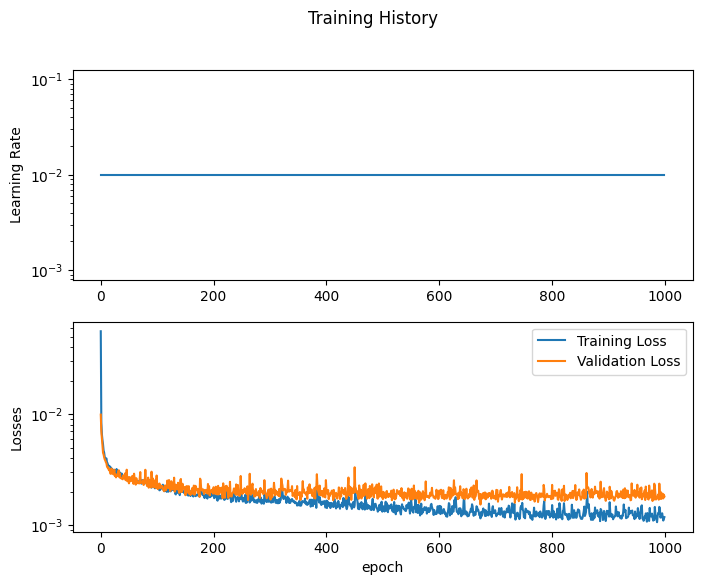

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [48]:
approx_mpc_nom=do_mpc.approximateMPC.ApproxMPC(mpc_nom)
approx_mpc_nom.settings.n_hidden_layers = 3
approx_mpc_nom.settings.n_neurons = 50
approx_mpc_nom.settings.lbx[-1]=0
approx_mpc_nom.settings.ubx[0,0:4]=torch.tensor([[30000],[25000],[2500],[363.15+2.5]]).T
approx_mpc_nom.setup()

lbx=np.array([10000.0-2000,853.0-53,26.5-1.5,90.0-10 + 273.15,90.0-10 + 273.15,90.0-10 + 273.15,35.0-10 + 273.15,35.0-10 + 273.15,300.0-200,375])
ubx=np.array([10000.0+2000,853.0+47,26.5+1.5,90.0+10 + 273.15,90.0+10 + 273.15,90.0+10 + 273.15,35.0+10 + 273.15,35.0+10 + 273.15,300.0+200,380])
trainer= do_mpc.approximateMPC.Trainer(approx_mpc_nom)
trainer.settings.n_samples = 400
trainer.settings.n_epochs = 1000
trainer.setup()
trainer.default_training()
#approx_mpc_nom.load_from_state_dict('approx_mpc_nom.pth')
app_mpc_list=[approx_mpc_nom]#[approx_mpc_nom,approx_mpc_back,approx_mpc_rob]
N_sim=100
for m in range(M):
    app_mpc=app_mpc_list[m]
    np.random.seed(42)
    phi_max_list= []
    for r in range(int(N)):
        print(r)
        x0=np.random.uniform(lbx,ubx).reshape((-1,1))
        simulator.reset_history()
        app_mpc.x0 = x0
        simulator.x0 = x0
        estimator.x0 = x0
        phi_list=[]
        for k in range(N_sim):
            p_num['delH_R'] = 950 * np.random.uniform(0.75,1.25)
            p_num['k_0'] = 7 * np.random.uniform(0.75*1.25)
            def p_fun(t_now):
                return p_num
            simulator.set_p_fun(p_fun)
            u0=app_mpc.make_step(x0)
            x0 = simulator.make_step(u0)
            if x0[3]>363.15+10:
                phi=x0[3][0]-(363.15+4)
            elif x0[3]<363.15-10:
                phi=363.15-4-x0[3][0]
            else:
                phi=0
            phi_list.append(phi)
        phi_list=np.array(phi_list)
        phi_max= np.max(phi_list)
        phi_max_list.append(phi_max)
    phi_max_ges=np.array(phi_max_list)
    print(phi_max_ges>0)
    print(np.sum(phi_max_ges > 0))
